In [1]:
# Import der Bibliotheken

import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import date, datetime
import plotly

In [2]:
# Konfiguration der Grafiken

plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.autolayout'] = False

plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 14
plt.rcParams['legend.fontsize'] = 12

plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 8

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14


# Definition von Funktionen

In [3]:
# Funktion für die Abbildungen

def Jahresverlauf (Titel, Zeitstempel, Leistung, xlabel, ylabel):

  fig = plt.figure(figsize=(19,8))

 

  ax1 = fig.add_axes([1, 1, 1, 1])
  ax1.set_title(Titel,weight='bold',fontsize=15)
  ax1.plot(Zeitstempel,Leistung,c='green')
  plt.xlabel(xlabel,fontsize=15 )
  plt.ylabel(ylabel,fontsize=15)

 

  plt.show()

# Einlesen der Datenreihen

In [4]:
# Einlesen externen Daten
data_pv = pd.read_csv('data/data_pv_antofagasta_1MW.csv', skiprows = 3)
data_wind = pd.read_csv('data/data_wind_antofagasta_1MW.csv', skiprows = 3)
data_shipping_1 = pd.read_excel('data/Ferntransport_12.xlsx')

In [5]:
# Erstellung eines Dataframes aus externen Daten

dataset_df=pd.DataFrame()
dataset_df['Zeitstempel']=data_pv['time']
dataset_df['PV_Erzeugung']=data_pv['electricity']
dataset_df['Wind_Erzeugung']=data_wind['electricity']
dataset_df['Kapazität_Schiff']=data_shipping_1['10 Fahrten pro Jahr mit Betankung']
dataset_df.Kapazität_Schiff=dataset_df.Kapazität_Schiff.fillna(method='ffill')
#dataset_df

In [6]:
# Einlesen und Ausgabe der Inputs für die Variablen

data_inputs = pd.read_excel('data/Inputs_Modell.xlsx', sheet_name = 'Gesamt', header = 2, index_col = 0, nrows = 20)

data_inputs=pd.DataFrame(data_inputs.fillna(0)).drop(columns = ['Unnamed: 1','name','bus','p_nom','Unnamed: 10','Unnamed: 11'])
data_inputs

,marginal_cost,lifetime,capital_cost,efficiency,standing_loss
NaN,static,float,float,float,float
Photovoltaik (Chile),38.8,20,1333000,n.v.,n.v.
Windkraft (Chile),30,20,1462000,n.v.,n.v.
Entsalzung,0,0,0,0,n.v.
PEM Elektrolyse,95.226003,10,720000,0.598911,n.v.
AEL Elektrolyse,120.831319,10,630000,0.617978,n.v.
Verflüssigung,6.060606,20,3296969.69697,1,n.v.
Haber-Bosch,0,0,0,0,n.v.
Hydrierung,1325,20,53000,0.99,n.v.
Regasifizierung,0,0,0,0,n.v.


# Definition der Variablen

In [7]:
# Erstellung der Last durch den Wasserstoffbedarf

hydrogen_energy_content = 33 #kWh/kg oder MWh/t
hydrogen_demand_t = 35 * 1000
hydrogen_demand_kg = hydrogen_demand_t * 1000
hydrogen_demand_MWh = hydrogen_demand_t * hydrogen_energy_content # MWh
hydrogen_demand_hourly = hydrogen_demand_MWh/8760 #MW

print('Der stündliche Bedarf bei konstanter Verteilung des Jahresbedarfs von 35 kt Wasserstoff beträgt ungefähr ' + str(round(hydrogen_demand_hourly,0)) + ' MWh')

Der stündliche Bedarf bei konstanter Verteilung des Jahresbedarfs von 35 kt Wasserstoff beträgt ungefähr 132.0 MWh


In [8]:
# Neberechnung der Effizienz der Entsalzungsanlage TODO: spez. Strombedarf überprüfen

demand_electricity_kWh = 3.7 # kWh/m3 Salzwasser zu Süßwasser
demand_electricity_MWh = demand_electricity_kWh/1000
demand_water = 9 # l/kg oder m3/t Süßwasser zu Wasserstoff

eff_desalination = (1-(demand_electricity_MWh*demand_water)/hydrogen_energy_content)
eff_desalination

print('Der durch den Strombedarf beeinflusste Wirkungsgrad der Entsalzungsanlage liegt bei '+str(round(eff_desalination*100,2))+' %.'+'\n\n'+'Dieser wird mit dem Wirkungsgrad der Elektrolyse verrechnet.')
#print('Der stündliche Bedarf bei konstanter Verteilung des Jahresbedarfs für die Entsalzungsanlage beträgt ungefähr ' + str(round(p_desalination,0)) + ' MWh')

Der durch den Strombedarf beeinflusste Wirkungsgrad der Entsalzungsanlage liegt bei 99.9 %.

Dieser wird mit dem Wirkungsgrad der Elektrolyse verrechnet.


In [9]:
# Nebenrechnung für den Strombedarf verschiedener Komponenten



In [10]:
# Nebenrechnung für die maximale Beladung der Schiffe

# Die zusätzlich benötigten Substanzen für NH3 und LOHC werden im Modell vernachlässigt. 
# Es wird lediglich auf den transportierten Wasserstoff Bezug genommen und dieser anteilig berechnet

vmax_ship = 160000 # Maximale Beladung in m3
time_ship = 364 # Fahrtzeit pro Trip in h

# Dichte der Stoff(mischungen)
roh_LH2 = 71.1 # kg/m3
roh_NH3 = 682.8 # kg/m3
roh_LOHC = 500 # kg m3 TODO: Recherche

# Anteil von Wasserstoff an der Gesamtmasse
m_H2_LH2 = 1 # 100 %
m_H2_NH3 = 0.18 # 18 %
m_H2_LOHC = 0.1 # %

# Maximale Beladung der Schiffe in t
m_max_ship_LH2 = (vmax_ship * roh_LH2)
m_max_ship_NH3 = (vmax_ship * roh_NH3)
m_max_ship_LOHC = (vmax_ship * roh_LOHC)

# Maximale Beladung der Schiffe in MWh pro Snapshot
p_max_ship_LH2 = (m_max_ship_LH2 * m_H2_LH2 * hydrogen_energy_content/1000)/time_ship
p_max_ship_NH3 = (m_max_ship_NH3 * m_H2_NH3 * (hydrogen_energy_content/1000))/time_ship
p_max_ship_LOHC = (m_max_ship_LOHC * m_H2_LOHC * hydrogen_energy_content/1000)/time_ship

print('Die maximale Beladung des LH2-Schiffes beträgt '+str(m_max_ship_LH2/1000)+' Tonnen pro Fahrt, wovon '+str(m_H2_LH2*100)+' % Wasserstoff ist.'+"\n")
print('Die maximale Beladung des NH3-Schiffes beträgt '+str(m_max_ship_NH3/1000)+' Tonnen pro Fahrt, wovon '+str(m_H2_NH3*100)+' % Wasserstoff ist.'+"\n")
print('Die maximale Beladung des LOHC-Schiffes beträgt '+str(m_max_ship_LOHC/1000)+' Tonnen pro Fahrt, wovon '+str(m_H2_LOHC*100)+' % Wasserstoff ist.'+"\n")

Die maximale Beladung des LH2-Schiffes beträgt 11376.0 Tonnen pro Fahrt, wovon 100 % Wasserstoff ist.

Die maximale Beladung des NH3-Schiffes beträgt 109248.0 Tonnen pro Fahrt, wovon 18.0 % Wasserstoff ist.

Die maximale Beladung des LOHC-Schiffes beträgt 80000.0 Tonnen pro Fahrt, wovon 10.0 % Wasserstoff ist.



## Investitionskosten

In [11]:
# capital_cost

# Erzeugung
capital_cost_pv = data_inputs.loc['Photovoltaik (Chile)']['capital_cost'] # €/MW
capital_cost_wind = data_inputs.loc['Windkraft (Chile)']['capital_cost'] # €/MW


# Elektrolyse
capital_cost_PEMEL = data_inputs.loc['PEM Elektrolyse']['capital_cost'] # €/MW
capital_cost_AEL = data_inputs.loc['AEL Elektrolyse']['capital_cost'] # €/MW


# Umwandlung
capital_cost_desalination = 0 # data_inputs.loc['Entsalzung']['capital_cost'] # €/MW
capital_cost_LH2 = data_inputs.loc['Verflüssigung']['capital_cost'] # €/MW
capital_cost_NH3 = data_inputs.loc['Haber-Bosch']['capital_cost'] # €/MW
capital_cost_LOHC = data_inputs.loc['Hydrierung']['capital_cost'] # €/MW
capital_cost_LH2_b = data_inputs.loc['Regasifizierung']['capital_cost'] # €/MW
capital_cost_NH3_b = data_inputs.loc['NH3 Cracker']['capital_cost'] # €/MW
capital_cost_LOHC_b = data_inputs.loc['Dehydrierung']['capital_cost'] # €/MW


#Transport
capital_cost_pipeline = data_inputs.loc['Pipeline']['capital_cost'] # €/MW
capital_cost_shipping_LH2 = data_inputs.loc['LH2 Schiff']['capital_cost'] # €/MW
capital_cost_shipping_NH3 = data_inputs.loc['NH3 Schiff']['capital_cost'] # €/MW
capital_cost_shipping_LOHC = data_inputs.loc['LOHC Schiff']['capital_cost'] # €/MW


# Speicherung
capital_cost_storage_el = 1000000 #data_inputs.loc['Stromspeicher']['capital_cost']
capital_cost_storage_LH2 = data_inputs.loc['LH2 Speicher']['capital_cost'] # €/MW
capital_cost_storage_NH3 = data_inputs.loc['NH3 Speicher']['capital_cost'] # €/MW
capital_cost_storage_LOHC = data_inputs.loc['LOHC Speicher']['capital_cost'] # €/MW
capital_cost_storage_GH2 = data_inputs.loc['GH2 Speicher']['capital_cost'] # €/MW

## Gestehungskosten

In [12]:
# marginal_cost

# Erzeugung
marginal_cost_pv = data_inputs.loc['Photovoltaik (Chile)']['marginal_cost'] # €/MWh
marginal_cost_wind = data_inputs.loc['Windkraft (Chile)']['marginal_cost'] # €/MWh

# Elektrolyse
marginal_cost_PEMEL = data_inputs.loc['PEM Elektrolyse']['marginal_cost'] # €/MWh
marginal_cost_AEL = data_inputs.loc['AEL Elektrolyse']['marginal_cost'] # €/MWh

# Umwandlung
marginal_cost_desalination = 0 # data_inputs.loc['Entsalzung']['marginal_cost'] # €/MWh
marginal_cost_LH2 = data_inputs.loc['Verflüssigung']['marginal_cost'] # €/MWh
marginal_cost_NH3 = data_inputs.loc['Haber-Bosch']['marginal_cost'] # €/MWh
marginal_cost_LOHC = data_inputs.loc['Hydrierung']['marginal_cost'] # €/MWh
marginal_cost_LH2_b = data_inputs.loc['Regasifizierung']['marginal_cost'] # €/MWh
marginal_cost_NH3_b = data_inputs.loc['NH3 Cracker']['marginal_cost'] # €/MWh
marginal_cost_LOHC_b = data_inputs.loc['Dehydrierung']['marginal_cost'] # €/MWh

# Transport
marginal_cost_pipeline = data_inputs.loc['Pipeline']['marginal_cost'] # €/MWh
marginal_cost_shipping_LH2 = data_inputs.loc['LH2 Schiff']['marginal_cost'] # €/MWh
marginal_cost_shipping_NH3 = data_inputs.loc['NH3 Schiff']['marginal_cost'] # €/MWh
marginal_cost_shipping_LOHC = data_inputs.loc['LOHC Schiff']['marginal_cost'] # €/MWh

# Speicherung
marginal_cost_storage_el = 0 #data_inputs.loc['Stromspeicher']['marginal_cost']
marginal_cost_storage_LH2 = data_inputs.loc['LH2 Speicher']['marginal_cost'] # €/MWh
marginal_cost_storage_NH3 = data_inputs.loc['NH3 Speicher']['marginal_cost'] # €/MWh
marginal_cost_storage_LOHC = data_inputs.loc['LOHC Speicher']['marginal_cost'] # €/MWh
marginal_cost_storage_GH2 = data_inputs.loc['GH2 Speicher']['marginal_cost'] # €/MWh

## Effizienzen

In [13]:
# efficiency

# Wirkungsgrad Erzeugung
efficiency_desalination = 0.98 # data_inputs.loc['Entsalzung']['efficiency']
efficiency_PEMEL = data_inputs.loc['PEM Elektrolyse']['efficiency'] * efficiency_desalination
efficiency_AEL = data_inputs.loc['AEL Elektrolyse']['efficiency'] * efficiency_desalination

# Wirkungsgrad Umwandlung
efficiency_LH2 = (hydrogen_energy_content/(hydrogen_energy_content+10)) # data_inputs.loc['Verflüssigung']['efficiency']
efficiency_NH3 = 1 # data_inputs.loc['Haber-Bosch']['efficiency']
efficiency_LOHC = data_inputs.loc['Hydrierung']['efficiency']

efficiency_LH2_b = 1 # data_inputs.loc['Regasifizierung']['efficiency']
efficiency_NH3_b = 1 # data_inputs.loc['NH3 Cracker']['efficiency']
efficiency_LOHC_b = data_inputs.loc['Dehydrierung']['efficiency']

# Wirkungsgrad der Transporte
efficiency_shipping_LH2 = data_inputs.loc['LH2 Schiff']['efficiency'] 
efficiency_shipping_NH3 = data_inputs.loc['NH3 Schiff']['efficiency']
efficiency_shipping_LOHC = data_inputs.loc['LOHC Schiff']['efficiency']


# Speicherverluste
standing_loss_el = 0.1 #data_inputs.loc['Stromspeicher']['standing_loss']
standing_loss_NH3 = data_inputs.loc['LH2 Speicher']['standing_loss']
standing_loss_LH2 = data_inputs.loc['NH3 Speicher']['standing_loss']
standing_loss_LOHC = data_inputs.loc['LOHC Speicher']['standing_loss']

## Lebenszeit

In [14]:
# lifetime

lifetime_pv = data_inputs.loc['Photovoltaik (Chile)']['lifetime']
lifetime_wind = data_inputs.loc['Windkraft (Chile)']['lifetime']

lifetime_desalination = 20 # data_inputs.loc['Entsalzung']['lifetime']

lifetime_PEMEL = data_inputs.loc['PEM Elektrolyse']['lifetime']
lifetime_AEL = data_inputs.loc['AEL Elektrolyse']['lifetime']

lifetime_NH3 = data_inputs.loc['Haber-Bosch']['lifetime']
lifetime_LH2 = data_inputs.loc['Verflüssigung']['lifetime']
lifetime_LOHC = data_inputs.loc['Hydrierung']['lifetime']

lifetime_LH2_b = data_inputs.loc['Regasifizierung']['lifetime']
lifetime_NH3_b = data_inputs.loc['NH3 Cracker']['lifetime']
lifetime_LOHC_b = data_inputs.loc['Dehydrierung']['lifetime']

lifetime_shipping_LH2 = data_inputs.loc['LH2 Schiff']['lifetime'] 
lifetime_shipping_NH3 = data_inputs.loc['NH3 Schiff']['lifetime']
lifetime_shipping_LOHC = data_inputs.loc['LOHC Schiff']['lifetime']

lifetime_storage_el = 20 #data_inputs.loc['Stromspeicher']['lifetime']
lifetime_storage_LH2 = data_inputs.loc['LH2 Speicher']['lifetime']
lifetime_storage_NH3 = data_inputs.loc['NH3 Speicher']['lifetime']
lifetime_storage_LOHC = data_inputs.loc['LOHC Speicher']['lifetime']

# Auswahl des Trägermediums und der Elektrolyseart

In [15]:
# Durch Eingabe der Elektrolyse wird der entsprechende Pfad aktiviert oder deaktiviert

electrolysis_PEMEL = True
electrolysis_AEL = True

In [16]:
# Durch Eingabe der Tägermedien wird der entsprechende Pfad aktiviert oder deaktiviert

carrier_LH2 = True
carrier_NH3 = False
carrier_LOHC = False

In [17]:
# Durch Eingabe der maximalen Erzeugungsleistungen werden die entsprechenden Komponenten limitiert

#limit_pv = 0
#limit_wind = 0
#limit_electrolysis = 0
#
#if limit_pv >= 0:    
#    p_nom_max_pv = limit_pv
#else:
#    p_nom_max_pv = 1000000
#    
#if limit_wind >= 0:    
#    p_nom_max_wind = limit_wind
#else:
#    p_nom_max_wind = 1000000
#
#if limit_electrolysis >= 0:    
#    p_nom_max_electrolysis = limit_electrolysis
#else:
#    p_nom_max_electrolysis = 1000000


p_nom_max_pv = 1000000
p_nom_max_wind = 1000000
p_nom_max_electrolysis = 1000

# Netzwerk aufbauen

In [18]:
network = pypsa.Network()
network.set_snapshots(range(8760))

## Buses

In [19]:
# Knotenpunkte

# Der Suffix _b steht für Bremerhaven
# Der Suffix _c steht für Chile

network.add('Bus', name = 'electricity1')
#network.add('Bus', name = 'electricity2')

network.add('Bus', name = 'GH2_b')
network.add('Bus', name = 'GH2_c')

if carrier_LH2:
    
    network.add('Bus', name = 'LH2_b')
    network.add('Bus', name = 'LH2_c')

if carrier_NH3:
    
    network.add('Bus', name = 'NH3_b')
    network.add('Bus', name = 'NH3_c')

if carrier_LOHC:
    
    network.add('Bus', name = 'LOHC_b')
    network.add('Bus', name = 'LOHC_c')

network.add('Bus', name = 'cologne')

## Load

In [20]:
network.add('Load', name = 'hydrogen_demand', bus = 'cologne', 
            p_set = hydrogen_demand_hourly)

## Generators

In [21]:
network.add('Generator', name = 'Photovoltaik', bus = 'electricity1', 
            p_nom_max = p_nom_max_pv,
            p_max_pu = dataset_df['PV_Erzeugung']/dataset_df['PV_Erzeugung'].max(), 
            p_min_pu = dataset_df['PV_Erzeugung']/dataset_df['PV_Erzeugung'].max(), 
            p_nom_extendable = True,
            marginal_cost = marginal_cost_pv, capital_cost = capital_cost_pv)

network.add('Generator', name = 'Windkraft', bus = 'electricity1',
            p_nom_max = p_nom_max_wind,
            p_max_pu = dataset_df['Wind_Erzeugung']/dataset_df['Wind_Erzeugung'].max(), 
            p_min_pu = dataset_df['Wind_Erzeugung']/dataset_df['Wind_Erzeugung'].max(), 
            p_nom_extendable = True,
            marginal_cost = marginal_cost_wind, capital_cost = capital_cost_wind)

## Link - Desalination

In [22]:
#network.add('Link', name = 'Entsalzung', bus0 = 'electricity1', bus1 = 'electricity2',
#            p_nom_extendable = True,
#            lifetime = lifetime_desalination,
#            marginal_cost = marginal_cost_desalination, 
#            capital_cost = capital_cost_desalination,
#            efficiency = efficiency_desalination)

## Links - Electrolysis

In [23]:
if electrolysis_PEMEL:

    network.add('Link', name = 'PEMEL', bus0 = 'electricity1', bus1 = 'GH2_c',
                p_nom_extendable = True,
                p_nom_max = p_nom_max_electrolysis,
                lifetime = lifetime_PEMEL,
                marginal_cost = marginal_cost_PEMEL, 
                capital_cost = capital_cost_PEMEL,
                efficiency = efficiency_PEMEL)

if electrolysis_AEL:
    
    network.add('Link', name = 'AEL', bus0 = 'electricity1', bus1 = 'GH2_c',
                p_nom_extendable = True,
                p_nom_max = p_nom_max_electrolysis,
                lifetime = lifetime_AEL,
                marginal_cost = marginal_cost_AEL, 
                capital_cost = capital_cost_AEL,
                efficiency = efficiency_AEL)

## Links - Conversion

In [24]:
if carrier_LH2:
    
    network.add('Link', name = 'Verflüssigung', bus0 = 'GH2_c', bus1 = 'LH2_c',
                p_nom_extendable = True,
                marginal_cost = marginal_cost_LH2, 
                capital_cost = capital_cost_LH2,
                efficiency = efficiency_LH2)

    network.add('Link', name = 'Regasifizierung', bus0 = 'LH2_b', bus1 = 'GH2_b',
                p_nom_extendable = True,
                marginal_cost = marginal_cost_LH2_b, 
                capital_cost = capital_cost_LH2_b,
                efficiency = efficiency_LH2_b)

if carrier_NH3:
    
    network.add('Link', name = 'Haber-Bosch', bus0 = 'GH2_c', bus1 = 'NH3_c',
                p_nom_extendable = True,
                marginal_cost = marginal_cost_NH3, 
                capital_cost = capital_cost_NH3,
                efficiency = efficiency_NH3)

    network.add('Link', name = 'NH3 Cracker', bus0 = 'NH3_b', bus1 = 'GH2_b',
                p_nom_extendable = True,
                marginal_cost = marginal_cost_NH3_b, 
                capital_cost = capital_cost_NH3_b,
                efficiency = efficiency_NH3_b)

if carrier_LOHC:
    
    network.add('Link', name = 'Hydrierung', bus0 = 'GH2_c', bus1 = 'LOHC_c',
                p_nom_extendable = True,
                marginal_cost = marginal_cost_LOHC, 
                capital_cost = capital_cost_LOHC,
                efficiency = efficiency_LOHC)

    network.add('Link', name = 'Dehydrierung', bus0 = 'LOHC_b', bus1 = 'GH2_b',
                p_nom_extendable = True,
                marginal_cost = marginal_cost_LOHC_b, 
                capital_cost = capital_cost_LOHC_b,
                efficiency = efficiency_LOHC_b)

## Links - Cargoship

In [25]:
if carrier_LH2:

    network.add('Link', name = 'Verschiffung LH2', bus0 = 'LH2_c', bus1 = 'LH2_b',
                p_nom = dataset_df['Kapazität_Schiff'].max(),
                p_nom_max = p_max_ship_LH2,
                p_max_pu = dataset_df['Kapazität_Schiff']/dataset_df['Kapazität_Schiff'].max(), 
                p_min_pu = dataset_df['Kapazität_Schiff']/dataset_df['Kapazität_Schiff'].max(),
                p_nom_extendable = True,
                marginal_cost = marginal_cost_shipping_LH2, 
                capital_cost = capital_cost_shipping_LH2)

if carrier_NH3:

    network.add('Link', name = 'Verschiffung NH3', bus0 = 'NH3_c', bus1 = 'NH3_b',
                p_nom = dataset_df['Kapazität_Schiff'].max(),
                p_nom_max = p_max_ship_NH3,
                p_max_pu = dataset_df['Kapazität_Schiff']/dataset_df['Kapazität_Schiff'].max(), 
                p_min_pu = dataset_df['Kapazität_Schiff']/dataset_df['Kapazität_Schiff'].max(),
                p_nom_extendable = True,
                marginal_cost = marginal_cost_shipping_NH3, 
                capital_cost = capital_cost_shipping_NH3)

if carrier_LOHC: 
    
    network.add('Link', name = 'Verschiffung LOHC', bus0 = 'LOHC_c', bus1 = 'LOHC_b',
                p_nom = dataset_df['Kapazität_Schiff'].max(),
                p_nom_max = p_max_ship_LOHC,
                p_max_pu = dataset_df['Kapazität_Schiff']/dataset_df['Kapazität_Schiff'].max(), 
                p_min_pu = dataset_df['Kapazität_Schiff']/dataset_df['Kapazität_Schiff'].max(),
                p_nom_extendable = True,
                marginal_cost = marginal_cost_shipping_LOHC, 
                capital_cost = capital_cost_shipping_LOHC)

## Link - Pipeline

In [26]:
network.add('Link', name = 'Pipeline', bus0 = 'GH2_b', bus1 = 'cologne', 
            p_nom_extendable = True,
            marginal_cost = marginal_cost_pipeline, 
            capital_cost = capital_cost_pipeline)

## Storages

In [27]:
network.add('Store', name = 'Stromspeicher', bus = 'electricity1', 
            e_nom_extendable = True,  e_cyclic = True, 
            capital_cost = capital_cost_storage_el,
            marginal_cost = marginal_cost_storage_el,
            standing_loss = standing_loss_el,
            lifetime = lifetime_storage_el)

if carrier_LH2:

    network.add('Store', name = 'Flüssigspeicher Chile', bus = 'LH2_c', 
                e_nom_extendable = True, e_cyclic = True,  
                capital_cost = capital_cost_storage_LH2, 
                marginal_cost = marginal_cost_storage_LH2,
                standing_loss = standing_loss_LH2,
                lifetime = lifetime_storage_LH2)

    network.add('Store', name = 'Flüssigspeicher Bremerhaven', bus = 'LH2_b', 
                e_nom_extendable = True, e_cyclic = True,  
                capital_cost = capital_cost_storage_LH2, 
                marginal_cost = marginal_cost_storage_LH2,
                standing_loss = standing_loss_LH2,
                lifetime = lifetime_storage_LH2)
    
if carrier_NH3:

    network.add('Store', name = 'Ammoniakspeicher Chile', bus = 'NH3_c', 
                e_nom_extendable = True,  e_cyclic = True, 
                capital_cost = capital_cost_storage_NH3, 
                marginal_cost = marginal_cost_storage_NH3,
                standing_loss = standing_loss_NH3,
                lifetime = lifetime_storage_NH3)

    network.add('Store', name = 'Ammoniakspeicher Bremerhaven', bus = 'NH3_b', 
                e_nom_extendable = True,  e_cyclic = True, 
                capital_cost = capital_cost_storage_NH3, 
                marginal_cost = marginal_cost_storage_NH3,
                standing_loss = standing_loss_NH3,
                lifetime = lifetime_storage_NH3)

if carrier_LOHC: 
    
    network.add('Store', name = 'LOHC-Speicher Chile', bus = 'LOHC_c', 
                e_nom_extendable = True, e_cyclic = True,  
                capital_cost = capital_cost_storage_LOHC, 
                marginal_cost = marginal_cost_storage_LOHC,
                standing_loss = standing_loss_LOHC,
                lifetime = lifetime_storage_LOHC)

    network.add('Store', name = 'LOHC-Speicher Bremerhaven', bus = 'LOHC_b', 
                e_nom_extendable = True, e_cyclic = True,  
                capital_cost = capital_cost_storage_LOHC, 
                marginal_cost = marginal_cost_storage_LOHC,
                standing_loss = standing_loss_LOHC,
                lifetime = lifetime_storage_LOHC)

# Grafische Darstellung der Ausgangsprofile

In [28]:
#Jahresverlauf('Stromerzeugung aus Windkraft',dataset_df.Zeitstempel.loc[2000:2055], dataset_df['Wind_Erzeugung'].loc[2000:2055],'Zeit','Leistung')

In [29]:
#Jahresverlauf('Stromerzeugung aus Photovoltaik',dataset_df.index, dataset_df['PV_Erzeugung'],'Zeit','Leistung')

In [30]:
#Jahresverlauf('Elektrolyse',dataset_df.index, dataset_df['Elektrolyse'],'Zeit','Leistung')

In [31]:
#Jahresverlauf('Ferntransport',dataset_df.index, dataset_df['Kapazität_Schiff'],'Zeit','Leistung')

# Optimierung des Systems

In [32]:
network.lopf(pyomo = False, solver_name = 'gurobi')

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.24s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Set parameter Username
Academic license - for non-commercial use only - expires 2023-07-01
Read LP format model from file /var/folders/np/fxyv4bts2s353fj5gdlrbgym0000gn/T/pypsa-problem-dce1r3t3.lp
Reading time = 0.69 seconds
obj: 271560 rows, 122652 columns, 525842 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 271560 rows, 122652 columns and 525842 nonzeros
Model fingerprint: 0xb74c2e79
Coefficient statistics:
  Matrix range     [1e-06, 1e+00]
  Objective range  [1e-01, 3e+06]
  Bounds range     [1e+03, 2e+06]
  RHS range        [1e+02, 1e+02]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 200238 rows and 86361 columns
Presolve time: 0.50s
Presolved: 71322 rows, 36291 columns, 221517 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 19
 AA' NZ     : 2.534e+05
 Factor NZ  : 1.141e+

INFO:pypsa.linopf:Optimization successful. Objective value: 6.28e+09


('ok', 'optimal')

In [33]:
#network.graph()
#network.iplot()

# Auswertung der Ergebnisse

## Ausgabe der Ergebnistabellen

### Installierte Leistungen, Kapazitäten und Volllststunden

In [34]:
# Ausgabe einer Ergebnistabelle der optimierten Leistungen in MW und optimierten Kapazitäten in MWh

df_results_1 = pd.DataFrame(network.generators['p_nom_opt'])
df_results_2 = pd.DataFrame(network.links['p_nom_opt'])
df_results_3 = pd.DataFrame(network.stores['e_nom_opt'])

frames = [df_results_1, df_results_2, df_results_3]

results_x = (pd.concat(frames).round(2).fillna(0).rename(columns = {'p_nom_opt':'Leistung [MW]','e_nom_opt':'Kapazität [MWh]'}))
results = results_x.loc[(results_x.sum(axis=1) != 0), (results_x.sum(axis=0) != 0)]


#results

In [35]:
# Berechnung der jährlichen Volllaststunden

df_flh_1 = pd.DataFrame((network.generators_t.p.sum())/network.generators.p_nom_opt)
df_flh_2 = pd.DataFrame((network.links_t.p0.sum())/network.links.p_nom_opt)

df_flh_x = df_flh_1.append(df_flh_2).round(0).fillna(0)
df_flh = df_flh_x.loc[(df_flh_x.sum(axis=1) != 0), (df_flh_x.sum(axis=0) != 0)]
df_flh = df_flh.rename(columns = {0:'Volllast [h]'}).fillna(0)
#df_flh

In [36]:
# Dataframe aller Ergebnisse 

results_sum = pd.concat([results,df_flh],axis=1).fillna(0)
results_sum

,Leistung [MW],Kapazität [MWh],Volllast [h]
Photovoltaik,1260.41,0.00,2437.0
PEMEL,208.97,0.00,2002.0
AEL,1000.00,0.00,2643.0
Verflüssigung,728.27,0.00,2535.0
Regasifizierung,131.85,0.00,8760.0
Verschiffung LH2,306.34,0.00,4130.0
Pipeline,131.85,0.00,8760.0
Stromspeicher,0.00,76.26,0.0
Flüssigspeicher Chile,0.00,82811.93,0.0
Flüssigspeicher Bremerhaven,0.00,63075.46,0.0


### Erzeugte und gespeicherte Energiemengen

In [37]:
# TODO: Spalten für Wasserstoffmengen in kg/t angeben
# Berechnung der Energiemengen in GWh

df_results_1 = pd.DataFrame(network.generators_t.p.sum()).rename(columns = {0:'Erzeugung [MWh/a]'})
df_results_2 = pd.DataFrame((-network.links_t.p1.sum())/hydrogen_energy_content).rename(columns = {0:'Erzeugung [t/a]'})
df_results_3 = pd.DataFrame((network.stores_t.e.sum())/hydrogen_energy_content).rename(columns = {0:'Erzeugung [t/a]'})

frames = [df_results_1, df_results_2, df_results_3]

results_x = (pd.concat(frames).round(2).fillna(0).rename(columns = {'0':'Leistung [MW]','e_nom_opt':'Kapazität [MWh]'}))
results = results_x.loc[(results_x.sum(axis=1) != 0), (results_x.sum(axis=0) != 0)]


results

,Erzeugung [MWh/a],Erzeugung [t/a]
Photovoltaik,3071892.17,0.00
PEMEL,0.00,7439.24
AEL,0.00,48496.37
Verflüssigung,0.00,42927.34
Regasifizierung,0.00,35000.00
Verschiffung LH2,0.00,38338.80
Pipeline,0.00,35000.00
Stromspeicher,0.00,3353.65
Flüssigspeicher Chile,0.00,11471367.29
Flüssigspeicher Bremerhaven,0.00,8346992.81


### Gestehungskosten Wasserstoff

In [38]:
# Berechnung des Wasserstoffpreises in €/kg

# Kilopreis der Generatoren
Generatorkosten = (((network.generators.capital_cost * network.generators.p_nom_opt)/network.generators.lifetime
                    + network.generators.marginal_cost * network.generators_t.p.sum())
                   /hydrogen_demand_kg)
     
Generatorkosten=pd.DataFrame(Generatorkosten,columns=['Preis [€/kg]'])
Generatorkosten['Generator']=Generatorkosten.index
Generatorkosten=Generatorkosten[['Preis [€/kg]']]

# Kilopreis der Links
Linkkosten = (((network.links.p_nom_opt * network.links.capital_cost)/network.links.lifetime
              + network.links.marginal_cost*(-network.links_t.p1.sum()))
              /hydrogen_demand_kg)

Linkkosten=pd.DataFrame(Linkkosten,columns=['Preis [€/kg]'])
Linkkosten['Link']=Linkkosten.index
Linkkosten=Linkkosten[['Preis [€/kg]']]

# Kilopreis der Speicher
Speicherkosten = (((network.stores.e_nom_opt * network.stores.capital_cost)/network.stores.lifetime
                   + network.stores.marginal_cost*network.stores_t.e.sum())
                  /hydrogen_demand_kg)

Speicherkosten=pd.DataFrame(Speicherkosten,columns=['Preis [€/kg]'])
Speicherkosten['Speicher']=Speicherkosten.index
Speicherkosten=Speicherkosten[['Preis [€/kg]']]

# Kilopreis gesamt

Kilogrammpreis = (Generatorkosten.append(Linkkosten).append(Speicherkosten))
Kilogrammpreis

,Preis [€/kg]
Photovoltaik,3.405412
Windkraft,0.000000
PEMEL,1.097805
AEL,7.325030
Verflüssigung,0.000000
Regasifizierung,0.000000
Verschiffung LH2,0.004015
Pipeline,0.128700
Stromspeicher,0.108940
Flüssigspeicher Chile,0.103246


In [39]:
# Erstellung der Dataframes zur Darstellung in den Kategorien

Kilogrammpreis_Strom = pd.DataFrame((Kilogrammpreis.iloc[[0,1]].append(Kilogrammpreis.loc[['Stromspeicher']]).sum())).rename(index={'Preis [€/kg]': 'Stromerzeugungskosten'})
Kilogrammpreis_Elektrolyse = pd.DataFrame(Kilogrammpreis.iloc[[2,3]].sum()).rename(index={'Preis [€/kg]': 'Elektrolysekosten'})
Kilogrammpreis_Umwandlung = pd.DataFrame(Kilogrammpreis.iloc[[4,5]].sum()).rename(index={'Preis [€/kg]': 'Umwandlungskosten'})
Kilogrammpreis_Transport = pd.DataFrame(Kilogrammpreis.iloc[[6,7]].sum()).rename(index={'Preis [€/kg]': 'Transportkosten'})
Kilogrammpreis_Speicherung = pd.DataFrame(Kilogrammpreis.iloc[[9,10]].sum()).rename(index={'Preis [€/kg]': 'Speicherkosten'})

Gestehungskosten_Wasserstoff = (Kilogrammpreis_Strom
                                .append(Kilogrammpreis_Elektrolyse)
                                .append(Kilogrammpreis_Umwandlung)
                                .append(Kilogrammpreis_Transport)
                                .append(Kilogrammpreis_Speicherung)).rename(columns = {0:'Gestehungspreis [€/kg]'})
Gestehungskosten_Wasserstoff

,Gestehungspreis [€/kg]
Stromerzeugungskosten,3.514352
Elektrolysekosten,8.422836
Umwandlungskosten,0.000000
Transportkosten,0.132715
Speicherkosten,0.181886


In [40]:
# Ausgabe des Ergebnisses
Gestehungskosten_Wasserstoff_EUR = float(round(Gestehungskosten_Wasserstoff.sum(),2))
print('Die Gestehungskosten für ein Kilogramm Wasserstoff liegen bei '+str(Gestehungskosten_Wasserstoff_EUR)+' €')

Die Gestehungskosten für ein Kilogramm Wasserstoff liegen bei 12.25 €


In [41]:
# Vergleich des Ergebnisses mit der Summe aus DF Kilogrammpreis

print('Die Gestehungskosten für ein Kilogramm Wasserstoff liegen bei '+str(float(Kilogrammpreis.sum().round(2)))+' €')

Die Gestehungskosten für ein Kilogramm Wasserstoff liegen bei 12.25 €


## Grafische Darstellungen

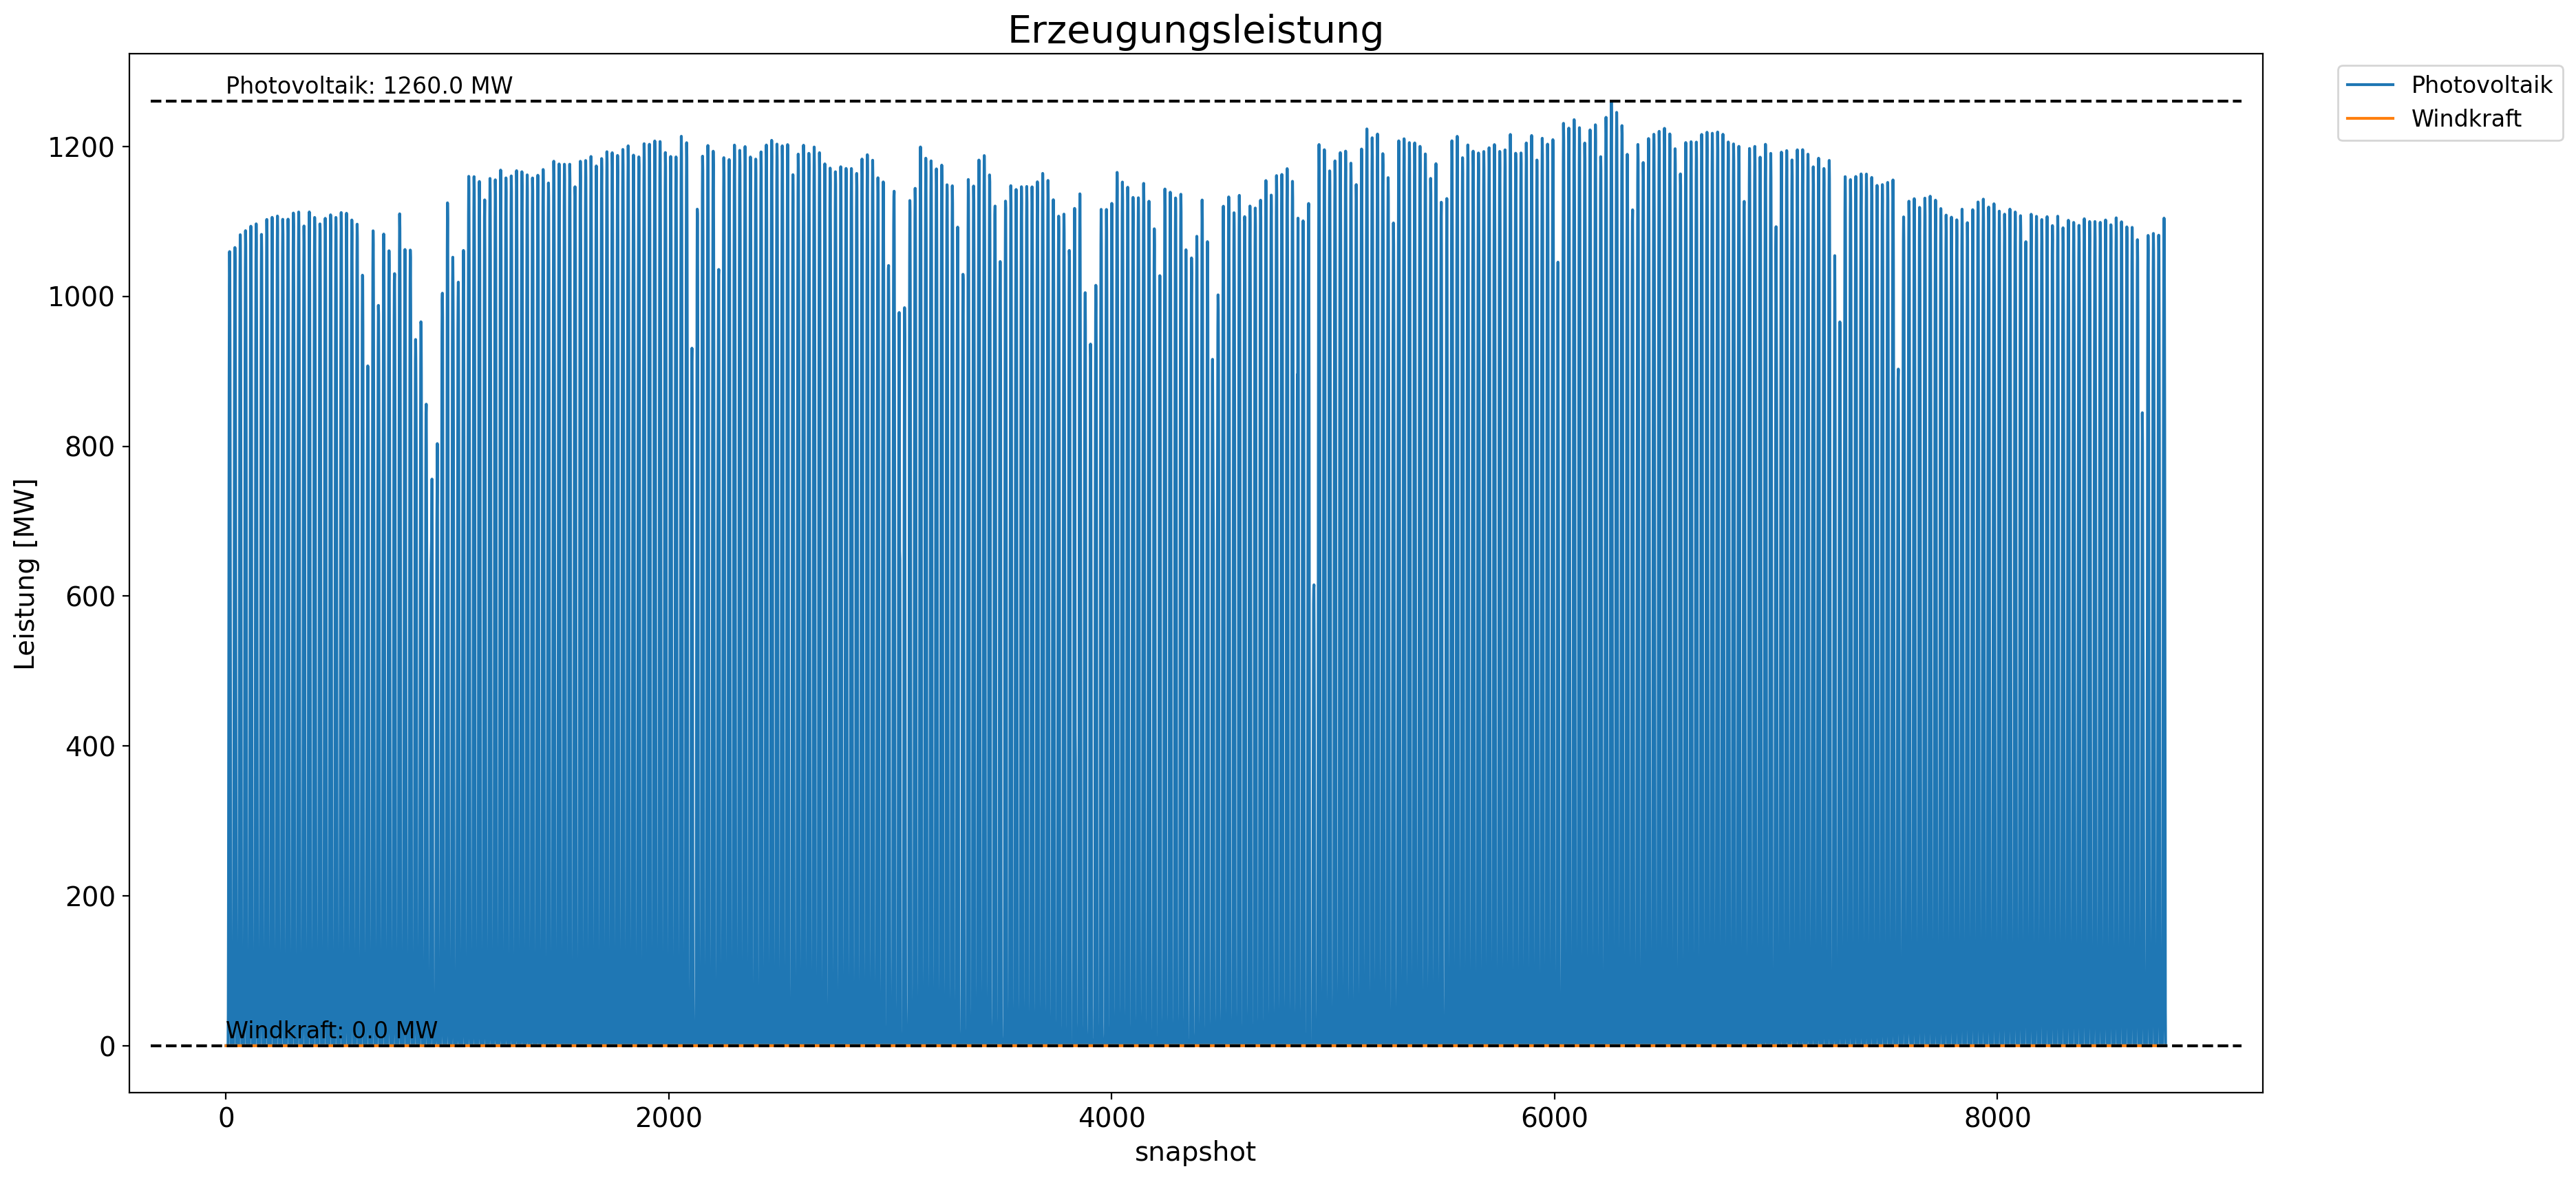

In [42]:
# Darstellung der optimierten Erzeugungsleistung

ax = network.generators_t.p.plot()

plt.axhline(y=network.generators_t.p['Photovoltaik'].max(), xmin=0.01, xmax=0.99, color = 'black', linestyle = "--")
plt.axhline(y=network.generators_t.p['Windkraft'].max(), xmin=0.01, xmax=0.99, color = 'black', linestyle = "--")

plt.text(s = 'Photovoltaik: '+str(network.generators.p_nom_opt.round(0)['Photovoltaik'])+' MW' , y = network.generators_t.p['Photovoltaik'].max() + 10, x = 0, color = 'black', fontsize = 12)
plt.text(s = 'Windkraft: '+str(network.generators.p_nom_opt.round(0)['Windkraft'])+' MW', y = network.generators_t.p['Windkraft'].max() + 10, x = 0, color = 'black', fontsize = 12)

ax.set_title('Erzeugungsleistung')
ax.set_ylabel("Leistung [MW]")
horiz_offset = 1.03
vert_offset = 1.
ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))
plt.show()                  

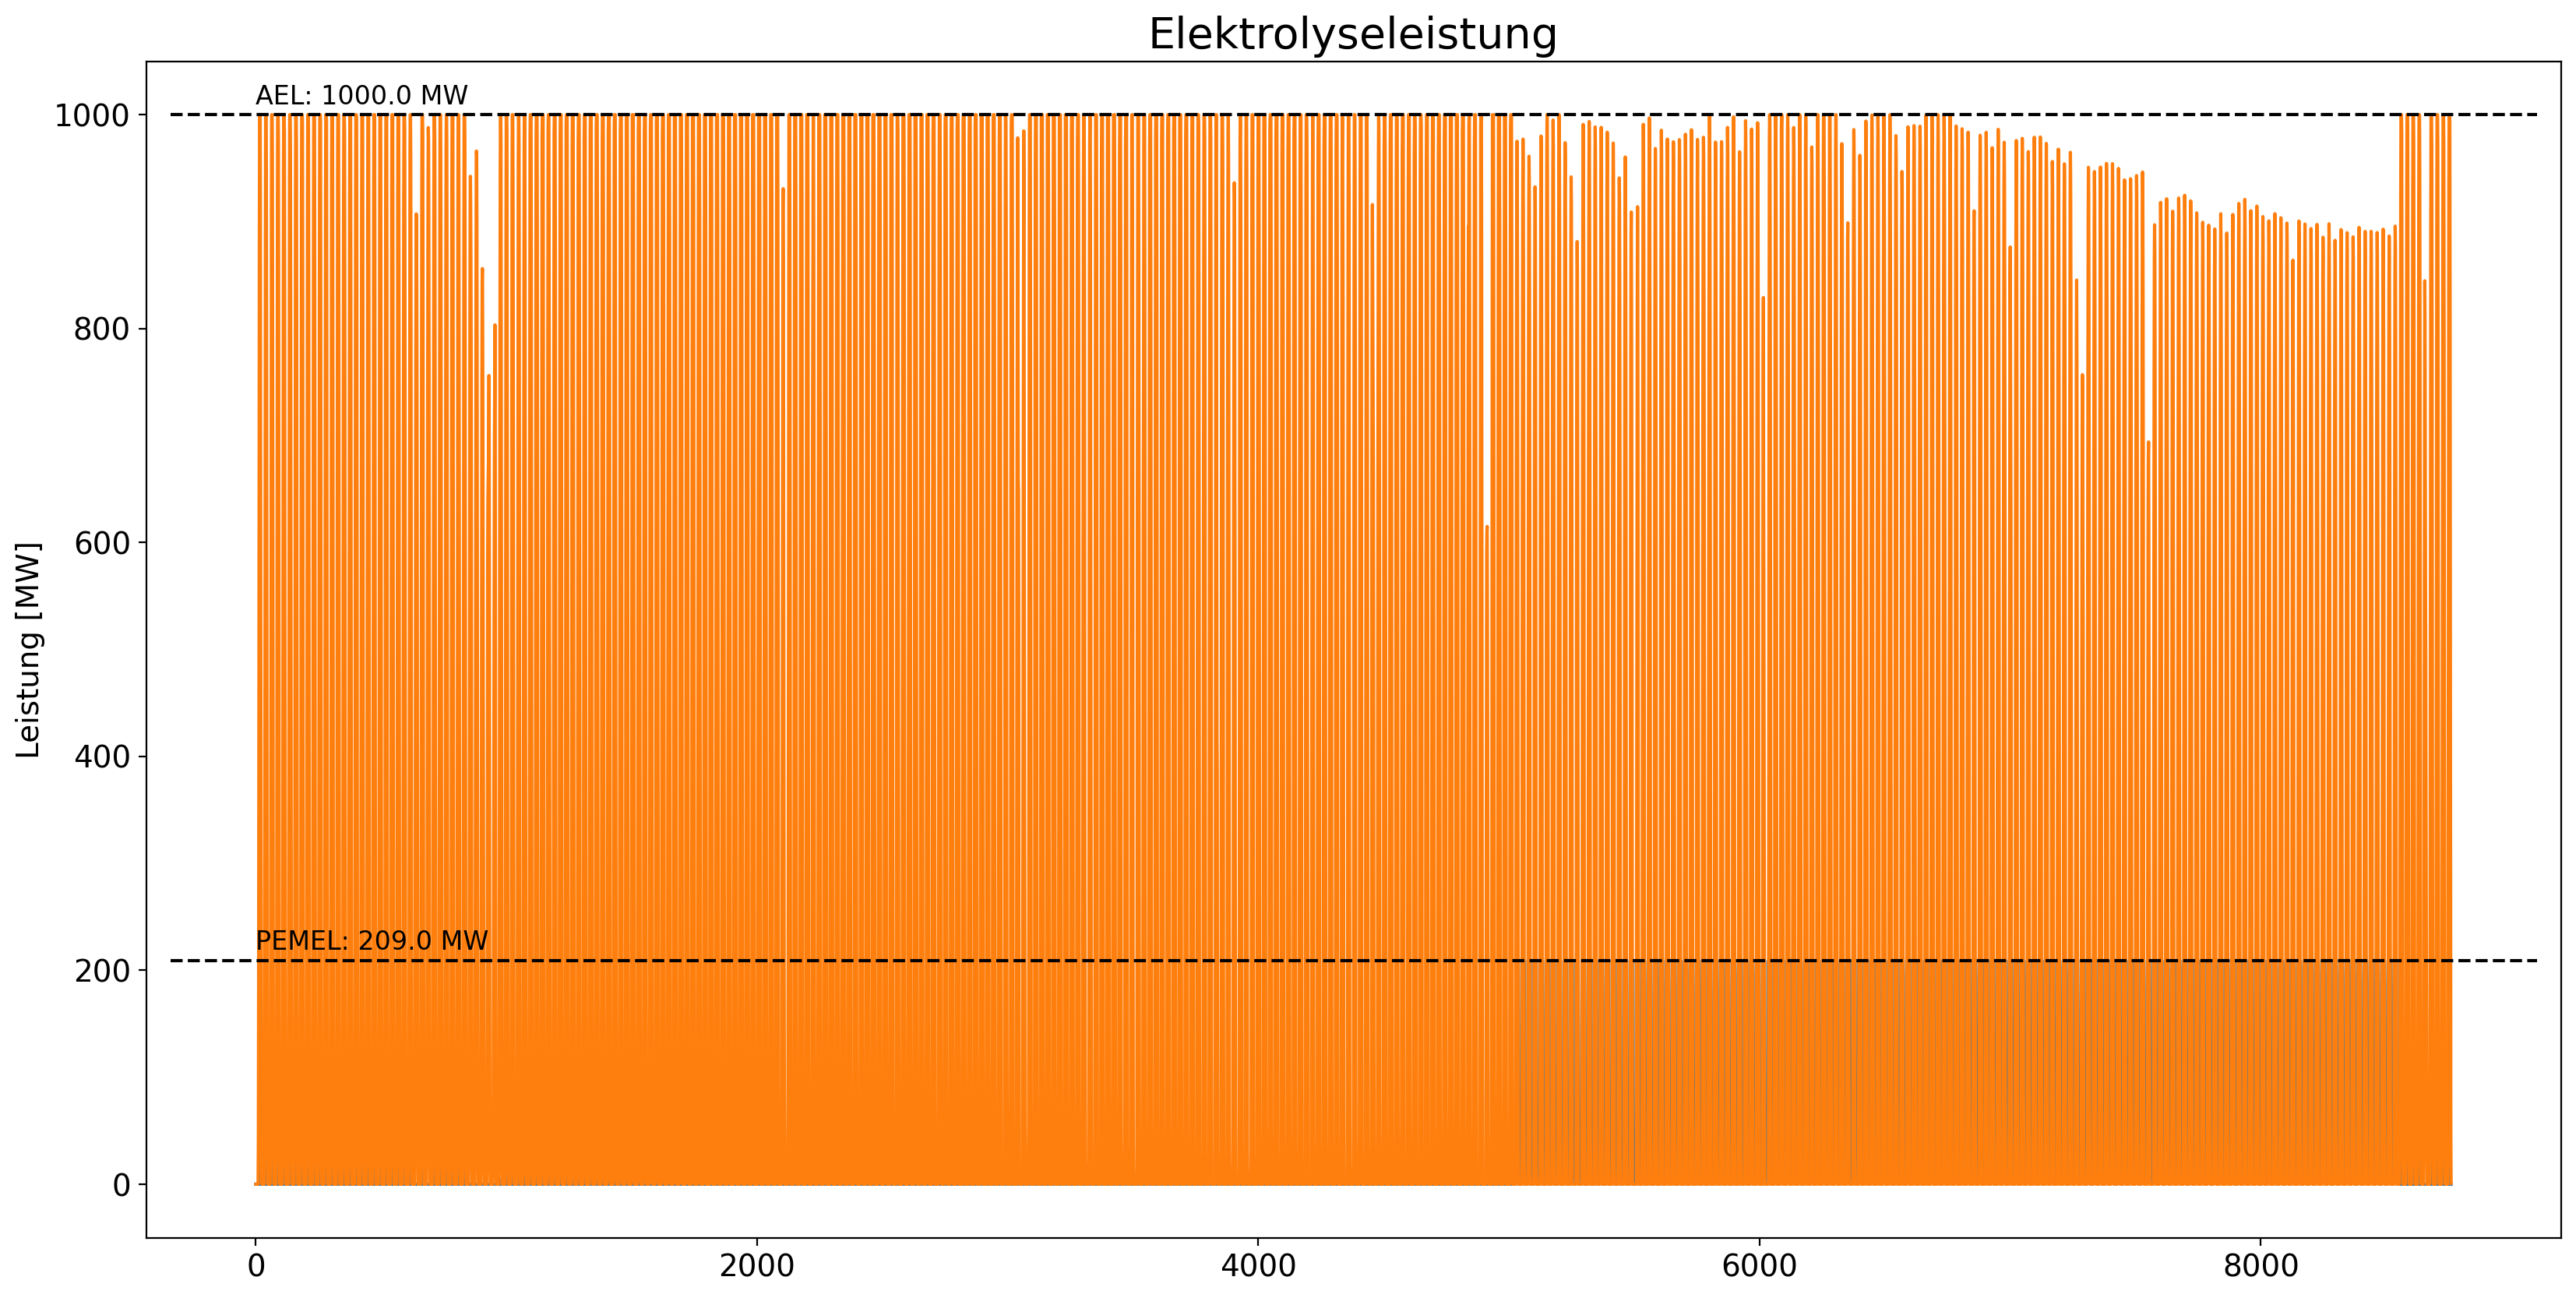

In [43]:
# Darstellung der optimierten Elektrolyseleistung

fig, ax = plt.subplots()

ax.plot(network.links_t.p0['PEMEL'])
ax.plot(network.links_t.p0['AEL'])

plt.axhline(y=network.links_t.p0['PEMEL'].max(), xmin=0.01, xmax=0.99, color = 'black', linestyle = "--")
plt.axhline(y=network.links_t.p0['AEL'].max(), xmin=0.01, xmax=0.99, color = 'black', linestyle = "--")

plt.text(s = 'PEMEL: '+str(network.links.p_nom_opt.round(0)['PEMEL'])+' MW' , y = network.links_t.p0['PEMEL'].max() + 10, x = 0, color = 'black', fontsize = 12)
plt.text(s = 'AEL: '+str(network.links.p_nom_opt.round(0)['AEL'])+' MW', y = network.links_t.p0['AEL'].max() + 10, x = 0, color = 'black', fontsize = 12)

ax.set_title('Elektrolyseleistung')
ax.set_ylabel("Leistung [MW]")
plt.show()         

### Vergleich von Umwandlung und Ferntransport

In [44]:
Betrachtungszeitraum = 5 #Tag(e)

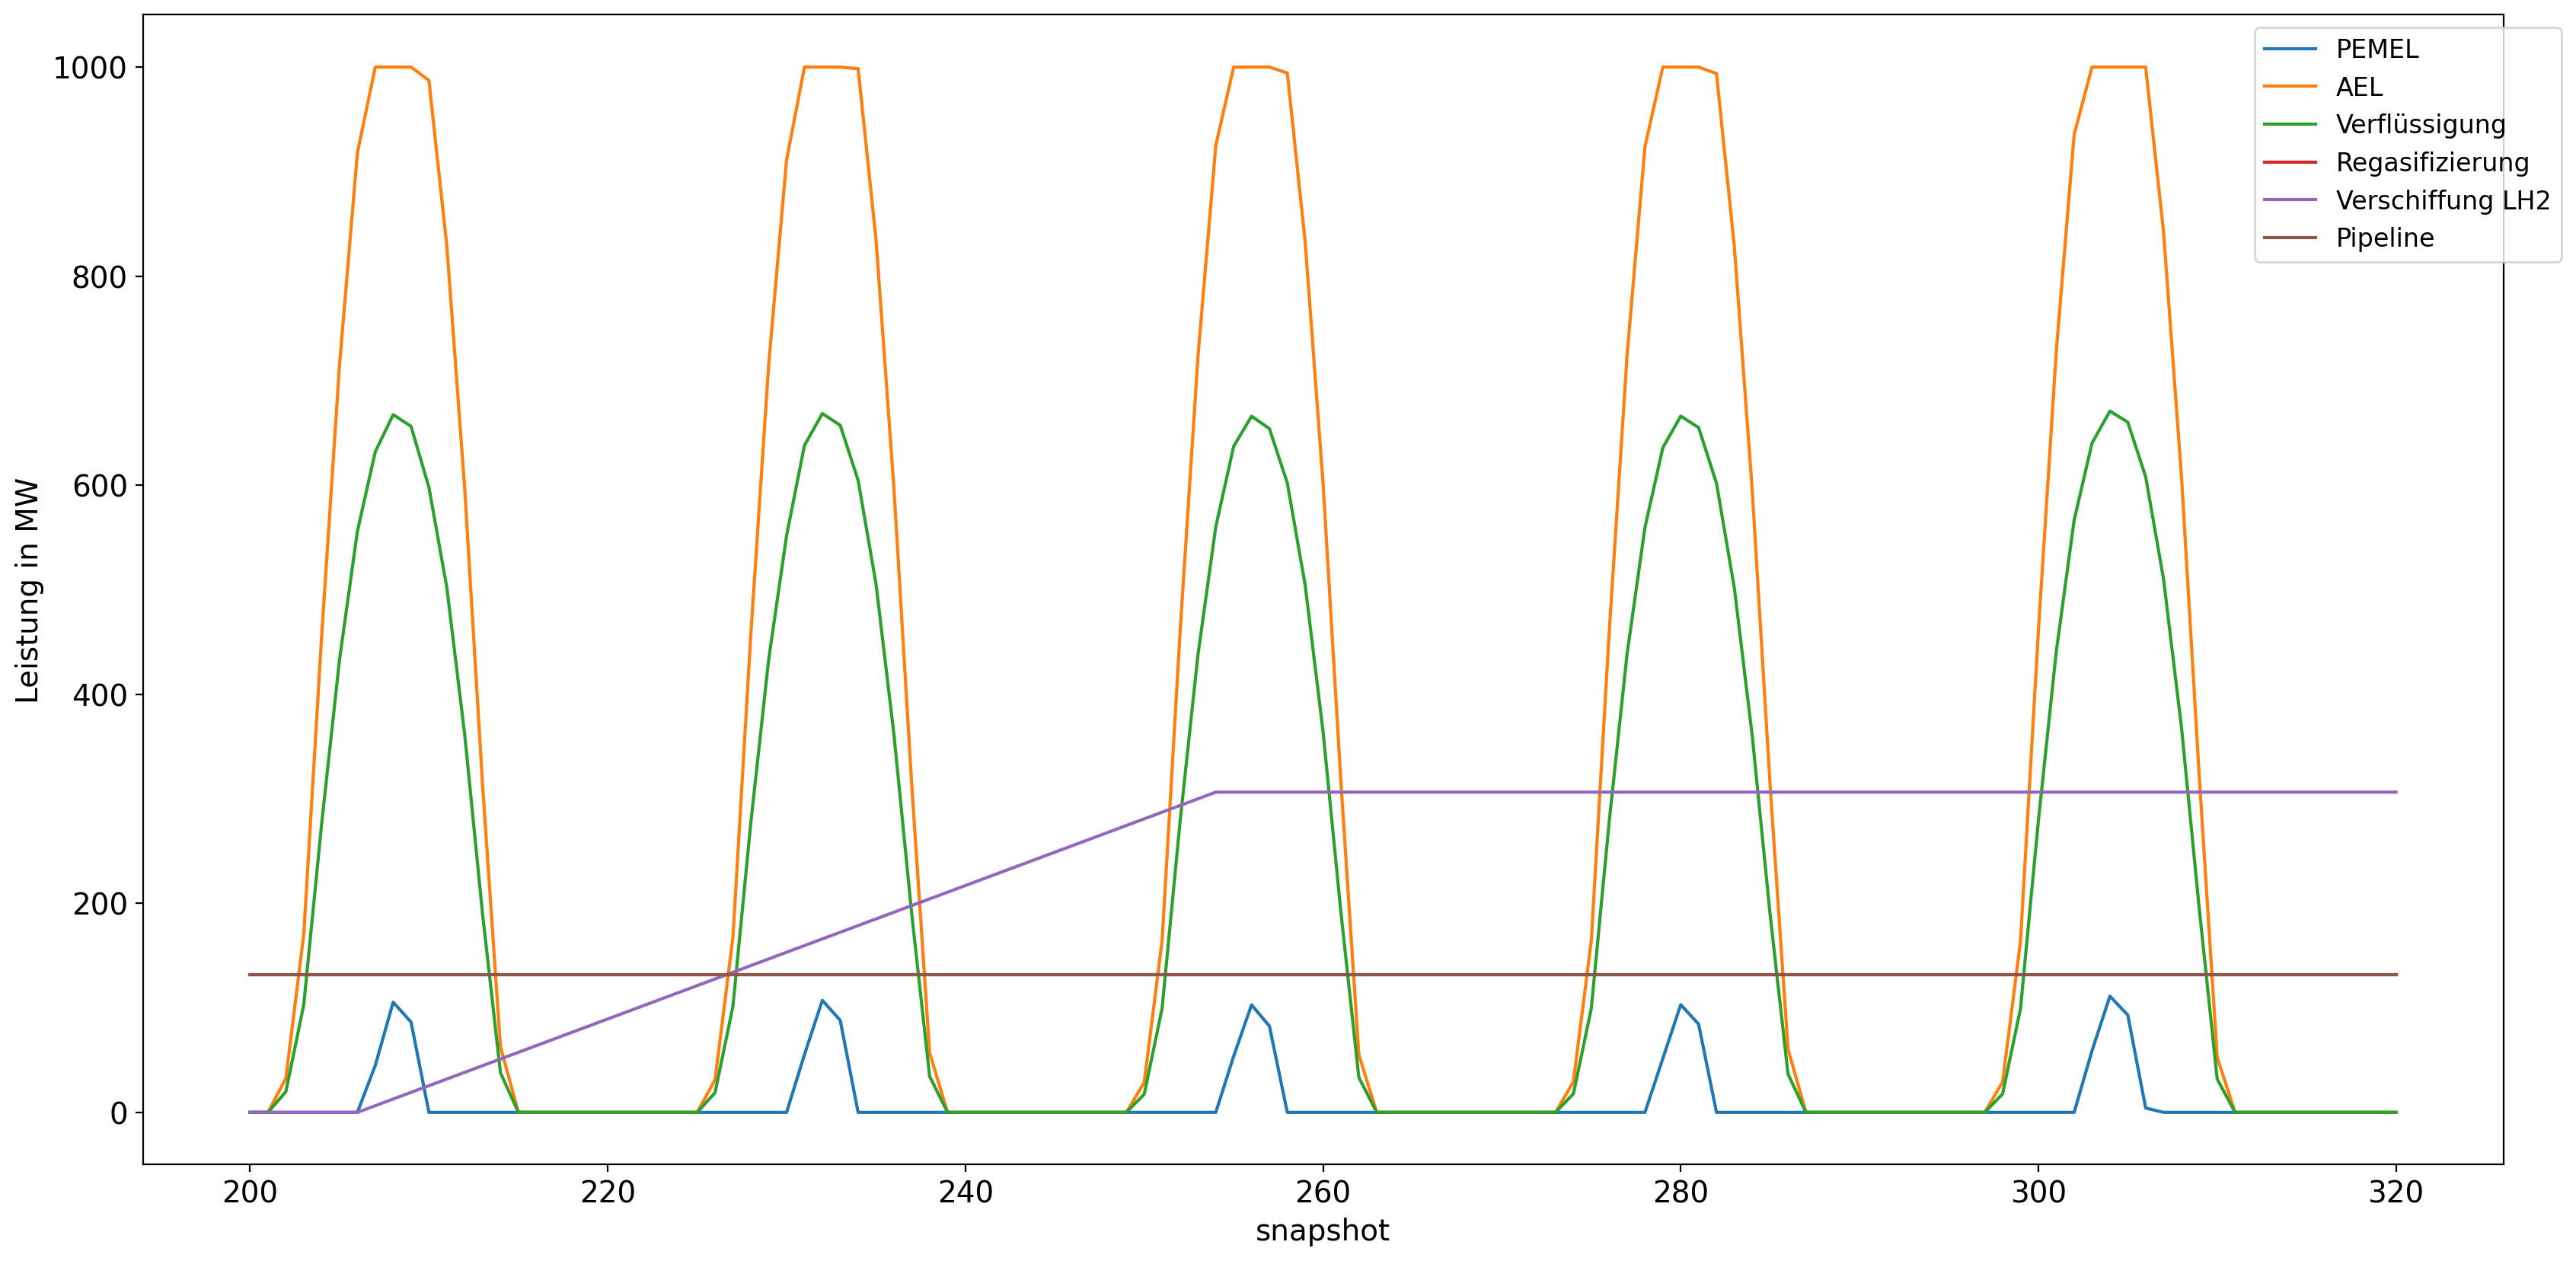

In [45]:
# Plot

a=200
b=a+Betrachtungszeitraum*24

ax=network.links_t.p0.loc[a:b].plot(ylabel = 'Leistung in MW')
horiz_offset = 1.03
vert_offset = 1.
ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))
plt.show()

### Vergleich von Speicherung und Ferntransport

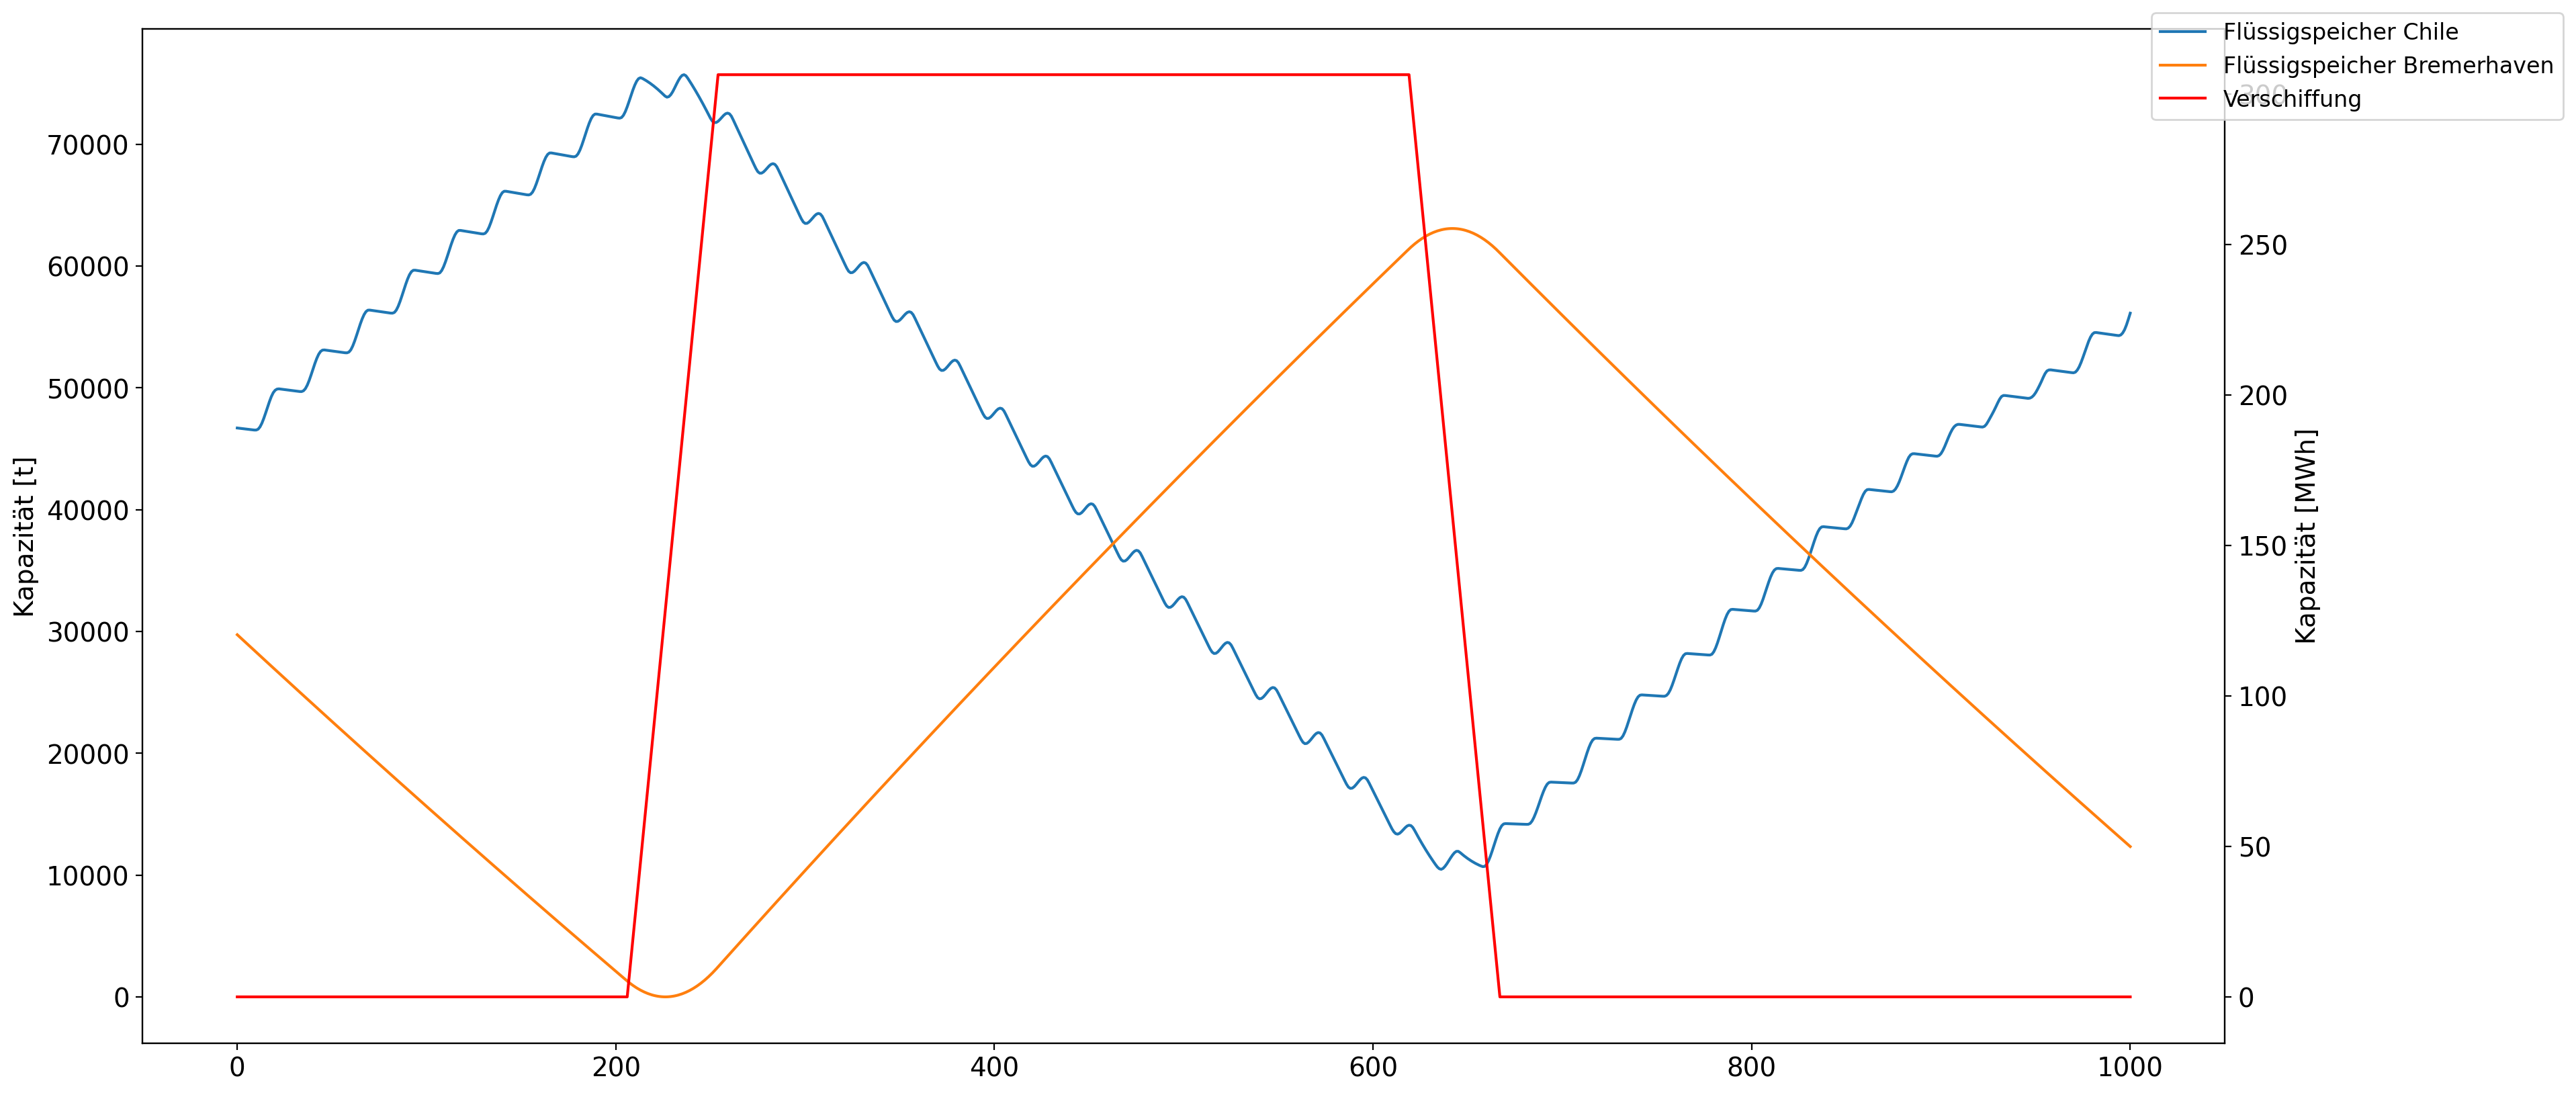

In [46]:
# Plot

a=0
b=1000
fig, ax1 = plt.subplots(sharey = True)

ax2 = ax1.twinx()
ax2.plot(network.links_t.p0['Verschiffung LH2'].loc[a:b],
        label = 'Verschiffung',color='red')
ax1.plot(network.stores_t.e['Flüssigspeicher Chile'].loc[a:b],
        label = 'Flüssigspeicher Chile')
ax1.plot(network.stores_t.e['Flüssigspeicher Bremerhaven'].loc[a:b],
        label = 'Flüssigspeicher Bremerhaven')
ax2.set_ylabel('Kapazität [MWh]')
ax1.set_ylabel('Kapazität [t]')


horiz_offset = 1.03
vert_offset = 0.90
fig.legend(bbox_to_anchor=(horiz_offset, vert_offset))
plt.show()

# Werkstatt

In [47]:
((-network.links_t.p1['AEL'].sum()/hydrogen_energy_content)*10*network.generators.marginal_cost.sum()/hydrogen_demand_kg)

0.9533001309750868

In [48]:
Gestehungskosten_Wasserstoff

,Gestehungspreis [€/kg]
Stromerzeugungskosten,3.514352
Elektrolysekosten,8.422836
Umwandlungskosten,0.000000
Transportkosten,0.132715
Speicherkosten,0.181886


array([<AxesSubplot:ylabel='Gestehungspreis [€/kg]'>], dtype=object)

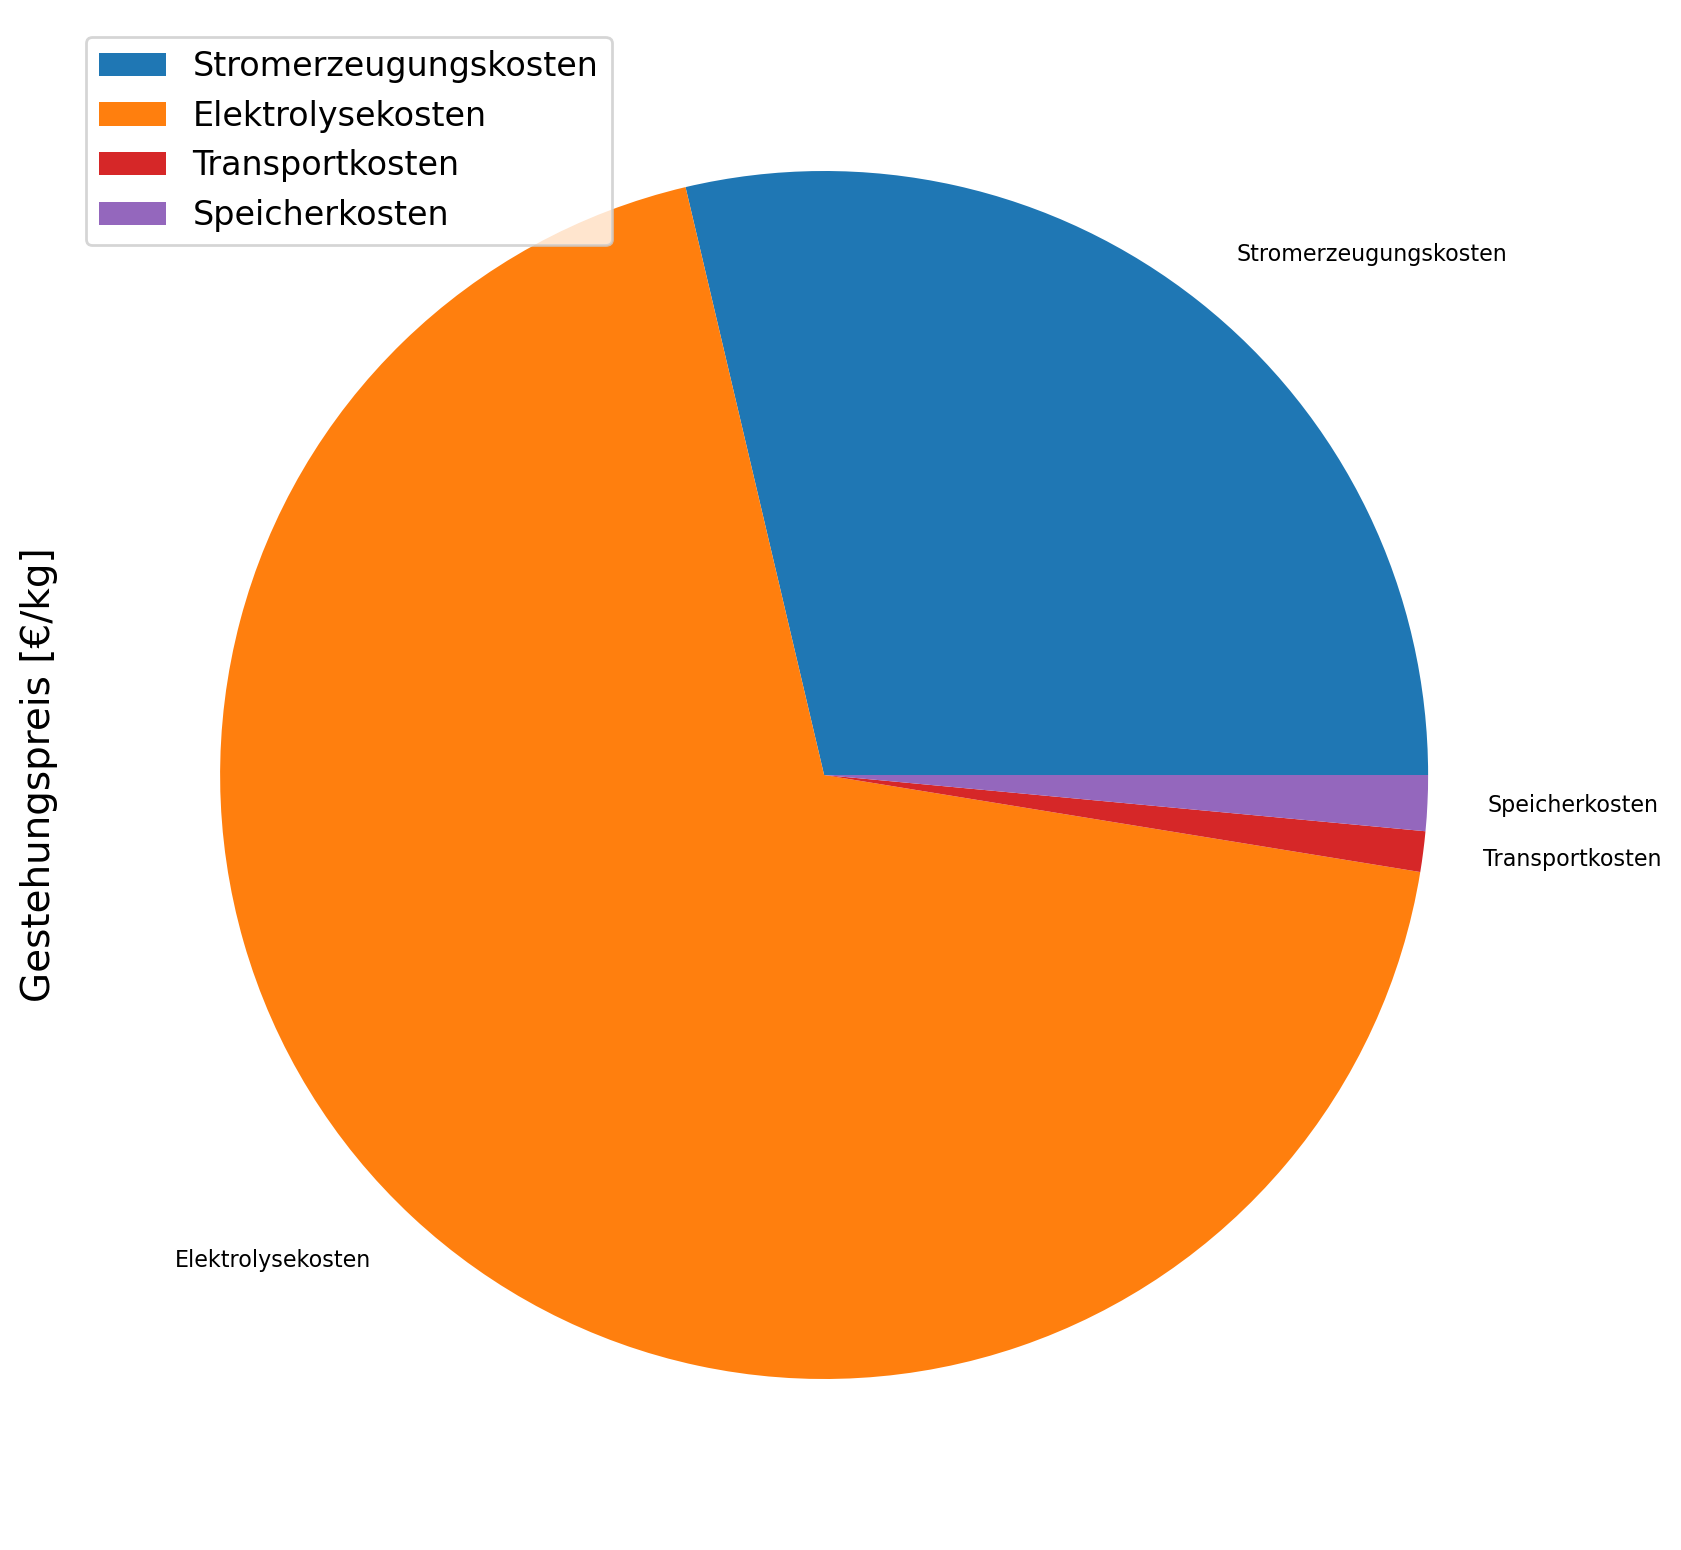

In [49]:
Gestehungskosten_Wasserstoff.plot.pie(subplots = True, fontsize = 8)

## Grafiken des Kilogrammpreises für alle Komponenten

In [50]:
#Wasserstoffbereitstellungskosten

Ergebnisse_Kosten=pd.DataFrame(columns=['AEL&LH2','AEL&LOHC','AEL&NH3','PEM&LH2','PEM&LOHC','PEM&NH3'],
                        index=['Stromgestehungskosten','Elektrolysekosten','Speicherung','Ferntransport',
                               'Umwandlung','Sonstige'])

In [51]:
Ergebnisse['AEL&LH2']['Stromgestehungskosten'] = 1.45
Ergebnisse['AEL&LH2']['Elektrolysekosten'] = 1.45
Ergebnisse['AEL&LH2']['Speicherung'] = 1.45
Ergebnisse['AEL&LH2']['Ferntransport'] = 1.45
Ergebnisse['AEL&LH2']['Umwandlung'] = 1.45

NameError: name 'Ergebnisse' is not defined

In [ ]:
Ergebnisse['AEL&LOHC']['Stromgestehungskosten'] = 1.45
Ergebnisse['AEL&LOHC']['Elektrolysekosten'] = 1.45
Ergebnisse['AEL&LOHC']['Speicherung'] = 1.45
Ergebnisse['AEL&LOHC']['Ferntransport'] = 1.45
Ergebnisse['AEL&LOHC']['Umwandlung'] = 1.45

In [ ]:
Ergebnisse['AEL&NH3']['Stromgestehungskosten'] = 1.45
Ergebnisse['AEL&NH3']['Elektrolysekosten'] = 1.45
Ergebnisse['AEL&NH3']['Speicherung'] = 1.45
Ergebnisse['AEL&NH3']['Ferntransport'] = 1.45
Ergebnisse['AEL&NH3']['Umwandlung'] = 1.45

In [ ]:
Ergebnisse['PEM&LH2']['Stromgestehungskosten'] = 1.45
Ergebnisse['PEM&LH2']['Elektrolysekosten'] = 1.45
Ergebnisse['PEM&LH2']['Speicherung'] = 1.45
Ergebnisse['PEM&LH2']['Ferntransport'] = 1.45
Ergebnisse['PEM&LH2']['Umwandlung'] = 1.45

In [ ]:
Ergebnisse['PEM&LOHC']['Stromgestehungskosten'] = 1.45
Ergebnisse['PEM&LOHC']['Elektrolysekosten'] = 1.45
Ergebnisse['PEM&LOHC']['Speicherung'] = 1.45
Ergebnisse['PEM&LOHC']['Ferntransport'] = 1.45
Ergebnisse['PEM&LOHC']['Umwandlung'] = 1.45

In [ ]:
Ergebnisse['PEM&NH3']['Stromgestehungskosten'] = 1.45
Ergebnisse['PEM&NH3']['Elektrolysekosten'] = 1.45
Ergebnisse['PEM&NH3']['Speicherung'] = 1.45
Ergebnisse['PEM&NH3']['Ferntransport'] = 1.45
Ergebnisse['PEM&NH3']['Umwandlung'] = 1.45

In [ ]:
# Übersicht der Kilopreise

labels = ['PEM & LH2', 'AEL & LH2']
Stromkosten = np.array([1.5,1.5])

Elektrolyse = np.array([hydrogen_price_links['PEMEL'],
                        hydrogen_price_links['AEL']])
Umwandlung = np.array([hydrogen_price_links['Verflüssigung'],
                       hydrogen_price_links['Verflüssigung']])
Ferntransport_1 = np.array([hydrogen_price_links['Verschiffung LH2'],
                            hydrogen_price_links['Verschiffung LH2']])
Inlandstransport = np.array([hydrogen_price_links['Pipeline'],
                             hydrogen_price_links['Pipeline']])

Speicherung = np.array([Speicherkosten['Value [€/kg]'][2]+Speicherkosten['Value [€/kg]'][4],
                        Speicherkosten['Value [€/kg]'][2]+Speicherkosten['Value [€/kg]'][4]])

Sonstige= np.array([0.1,0.3])
# the width of the bars: can also be len(x) sequence
width=0.5
fig, ax = plt.subplots(figsize=(14,8))
#x_pos = [-2,0,2]
ax.bar(labels, Stromkosten, label='Stromkosten',width=width,color='lightcoral')
ax.bar(labels, Elektrolyse, bottom=Stromkosten,
       label='Elektrolyse',width=width,color='indianred')
ax.bar(labels, Speicherung, bottom=Stromkosten+Elektrolyse,
       label='Speicherung',width=width,color='firebrick')
ax.bar(labels, Ferntransport_1, bottom=Stromkosten+Elektrolyse+Speicherung,
       label='Ferntransport',width=width,color='brown')
ax.bar(labels, Inlandstransport, bottom=Stromkosten+Elektrolyse+Speicherung+Ferntransport_1,
       label='Inlandstransport',width=width,color='maroon')
ax.bar(labels, Umwandlung, bottom=Stromkosten+Elektrolyse+Speicherung+Ferntransport_1+Inlandstransport,
       label='Umwandlung',width=width,color='darkred')
ax.bar(labels, Sonstige, bottom=Stromkosten+Elektrolyse+Speicherung+Ferntransport_1+Inlandstransport+Umwandlung,
       label='Sonstige',width=width,color='red')

ax.set_ylabel('Kosten in [€/kg]')
ax.set_title('Wasserstoffbereitstellungskosten in [€/kg]')
ax.legend(loc='upper right')

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.02f}€'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center',
            color='white',
            fontsize=10,
            )
  

horiz_offset = 1.03
vert_offset = 1.
ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))
#plt.xticks(x_pos, labels)
plt.show()

In [ ]:
# Übersicht der Kilopreise

labels = ['']

Stromkosten = Gestehungskosten_Wasserstoff['Gestehungspreis [€/kg]'].iloc[[0]]
Elektrolyse = Gestehungskosten_Wasserstoff['Gestehungspreis [€/kg]'].iloc[[1]]
Umwandlung = Gestehungskosten_Wasserstoff['Gestehungspreis [€/kg]'].iloc[[2]]
Transport = Gestehungskosten_Wasserstoff['Gestehungspreis [€/kg]'].iloc[[3]]
Speicherung = Gestehungskosten_Wasserstoff['Gestehungspreis [€/kg]'].iloc[[4]]

# the width of the bars: can also be len(x) sequence
width=0.5
fig, ax = plt.subplots(figsize=(14,14))
#x_pos = [-2,0,2]

ax.bar(labels, Stromkosten, 
       label='Stromkosten', width=width, color='lightcoral')
ax.bar(labels, Elektrolyse, bottom=Stromkosten,
       label='Elektrolyse', width=width, color='indianred')
ax.bar(labels, Speicherung, bottom=Stromkosten+Elektrolyse,
       label='Speicherung', width=width, color='firebrick')
ax.bar(labels, Transport, bottom=Stromkosten+Elektrolyse+Speicherung,
       label='Transport', width=width, color='brown')
ax.bar(labels, Umwandlung, bottom=Stromkosten+Elektrolyse+Speicherung+Transport,
       label='Umwandlung', width=width, color='darkred')

ax.set_ylabel('Kosten in [€/kg]')
ax.set_title('Wasserstoffbereitstellung')
ax.legend(loc='upper right')

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.02f}€'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center',
            color='white',
            fontsize=10,
            )
  

horiz_offset = 1.03
vert_offset = 1.
ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))
#plt.xticks(x_pos, labels)
plt.show()

In dieser Grafik spiele ich gerade ein bisschen rum, um eine Abbildung für die Präsentation morgen zu bekommen

TODO: Anstatt auf nummerierte Zeilen zuzugreifen, lieber auf die Benennung bzw inde

In [ ]:
# Übersicht der Kilopreise

labels = ['PEM & LH2', 'PEM & NH3', 'PEM & LOHC']
Stromkosten = np.array([1.5,1.5,1.5])

Elektrolyse = np.array([Linkkosten['Value [€/kg]'][0],
                        Linkkosten['Value [€/kg]'][0],
                        Linkkosten['Value [€/kg]'][0]])
Umwandlung = np.array([Linkkosten['Value [€/kg]'][2],0,0])
Ferntransport_1 = np.array([Linkkosten['Value [€/kg]'][3],0,0])
Inlandstransport = np.array([Linkkosten['Value [€/kg]'][4],0,0])

Speicherung = np.array([Speicherkosten['Value [€/kg]'][2]+Speicherkosten['Value [€/kg]'][4],0,0])

Sonstige= np.array([0.1,0.3,0.5])
# the width of the bars: can also be len(x) sequence
width=0.5
fig, ax = plt.subplots(figsize=(14,8))
#x_pos = [-2,0,2]
#ax.bar(labels, Stromkosten, label='Stromkosten',width=width,color='lightcoral')
ax.bar(labels, Elektrolyse, bottom=Stromkosten,
       label='Elektrolyse',width=width,color='indianred')
ax.bar(labels, Speicherung, bottom=Stromkosten+Elektrolyse,
       label='Speicherung',width=width,color='firebrick')
ax.bar(labels, Ferntransport_1, bottom=Stromkosten+Elektrolyse+Speicherung,
       label='Ferntransport',width=width,color='brown')
#ax.bar(labels, Inlandstransport, bottom=Stromkosten+Elektrolyse+Speicherung+Ferntransport_1,
#       label='Inlandstransport',width=width,color='maroon')
ax.bar(labels, Umwandlung, bottom=Stromkosten+Elektrolyse+Speicherung+Ferntransport_1+Inlandstransport,
       label='Umwandlung',width=width,color='darkred')
#ax.bar(labels, Sonstige, bottom=Stromkosten+Elektrolyse+Speicherung+Ferntransport_1+Inlandstransport+Umwandlung,
#       label='Sonstige',width=width,color='red')

ax.set_ylabel('Kosten in [€/kg]')
ax.set_title('Wasserstoffbereitstellung')
ax.legend(loc='upper right')

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.02f}€'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center',
            color='white',
            fontsize=10,
            )
  

horiz_offset = 1.03
vert_offset = 1.
ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))
#plt.xticks(x_pos, labels)
plt.show()

Ursprüngliche Grafik

In [ ]:
# Übersicht der Kilopreise

labels = ['PEM & LH2', 'AEL & LH2']
Stromkosten = np.array([Linkkosten['Value [€/kg]'][0],Linkkosten['Value [€/kg]'][1]])
Elektrolyse = np.array([2,1.5])
Speicherung = np.array([0.15,0.12])
Ferntransport_1 = np.array([1,0.2])
frachtfrafrachtfra
Umwandlung = np.array([0.7,0.3])
Sonstige= np.array([0.1,0.3])
# the width of the bars: can also be len(x) sequence
width=0.5
fig, ax = plt.subplots(figsize=(7,7))
#x_pos = [-2,0,2]
ax.bar(labels, Stromkosten, label='Stromkosten',width=width,color='lightcoral')
ax.bar(labels, Elektrolyse, bottom=Stromkosten,
       label='Elektrolyse',width=width,color='indianred')
ax.bar(labels, Speicherung, bottom=Stromkosten+Elektrolyse,
       label='Speicherung',width=width,color='firebrick')
ax.bar(labels, Ferntransport_1, bottom=Stromkosten+Elektrolyse+Speicherung,
       label='Ferntransport',width=width,color='brown')
ax.bar(labels, Inlandstransport, bottom=Stromkosten+Elektrolyse+Speicherung+Ferntransport_1,
       label='Inlandstransport',width=width,color='maroon')
ax.bar(labels, Umwandlung, bottom=Stromkosten+Elektrolyse+Speicherung+Ferntransport_1+Inlandstransport,
       label='Umwandlung',width=width,color='darkred')
ax.bar(labels, Sonstige, bottom=Stromkosten+Elektrolyse+Speicherung+Ferntransport_1+Inlandstransport+Umwandlung,
       label='Sonstige',width=width,color='red')

ax.set_ylabel('Kosten in [€]')
ax.set_title('Wasserstoffbereitstellungskosten in €/kg Wasserstoff')
ax.legend(loc='upper right')

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.02f}€'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center',
            color='white',
            fontsize=10,
            )
  

horiz_offset = 1.03
vert_offset = 1.
ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))
#plt.xticks(x_pos, labels)
plt.show()

## Archiv

In [ ]:
# Kilopreis der Links - ACHTUNG: veraltet und vermutlich falsch!!!
Linkkosten = ((network.links.p_nom_opt * network.links.capital_cost)/network.links.lifetime+network.links.marginal_cost*hydrogen_production_kg*(33/1000))/hydrogen_production_kg
Linkkosten=pd.DataFrame(Linkkosten,columns=['Value [€/kg]'])
Linkkosten['Link']=Linkkosten.index
Linkkosten=Linkkosten.reset_index(drop=True)
Linkkosten=Linkkosten[['Link','Value [€/kg]']]
Linkkosten

In [ ]:
# Test

# Gespeicherte Wasserstoffmenge in kg
hydrogen_storage_kg = (network.stores_t.e.sum()/(hydrogen_energy_content*1000)) #kg/a


# Betriebskosten pro Jahr
marginal_cost_links = network.links.marginal_cost * network.links_t.p0.sum() # €/a
marginal_cost_stores = network.stores.marginal_cost * network.stores_t.e.sum() # €/a

# Investitionskosten pro Jahr
capital_cost_links = network.links.capital_cost * network.links.p_nom_opt # €
capital_cost_stores = network.stores.capital_cost * network.stores.e_nom_opt # €

# Lebenszeit
lifetime_links = network.links.lifetime # €
lifetime_stores = network.stores.lifetime # €


# Kilopreis Links
hydrogen_price_links = ((((capital_cost_links/lifetime_links)+marginal_cost_links))/hydrogen_production_kg).round(2)

# Kilopreis Stores
hydrogen_price_stores = ((((capital_cost_stores/lifetime_stores)+marginal_cost_stores))/hydrogen_storage_kg).round(2)



In [ ]:
# Kilopreis der Generatoren     
electricity_price_MWh = ((network.generators.capital_cost * network.generators.p_nom_opt)/network.generators.lifetime 
                         + network.generators.marginal_cost * network.generators_t.p.sum())/network.generators_t.p.sum()
electricity_price_kg = electricity_price_MWh / hydrogen_energy_content
electricity_price_kg

In [ ]:
# Kaptialkosten pro kg Elektrolyse
electrolysis_capital_cost = (((links_electrolysis.T.loc['p_nom_opt'] * links_electrolysis.T.loc['capital_cost'])
                             /links_electrolysis.T.loc['lifetime'])/hydrogen_demand_kg)
electrolysis_capital_cost

In [ ]:
electrolysis_marginal_cost = (links_electrolysis.T.loc['marginal_cost'] * hydrogen_production_MWh)/hydrogen_production_kg
electrolysis_marginal_cost

In [ ]:
# Betriebskosten pro kg Elektrolyse
marginal_AEL = (-(network.links.marginal_cost['AEL'] * network.links_t.p0['AEL'].sum())
                /(network.links_t.p1['AEL'].sum()/(hydrogen_energy_content/1000))) # €/kg

marginal_PEMEL = (-(network.links.marginal_cost['PEMEL'] * network.links_t.p0['PEMEL'].sum())
                /(network.links_t.p1['PEMEL'].sum()/(hydrogen_energy_content/1000))) # €/kg

In [ ]:
#Kapitalkosten pro kg Elektrolyse
capital_AEL = (-((network.links.capital_cost['AEL'] * network.links.p_nom_opt['AEL'])
                 /network.links.lifetime['AEL'])/(network.links_t.p1['AEL'].sum()
                                                  /(hydrogen_energy_content/1000))) # €/kg

capital_PEMEL = (-((network.links.capital_cost['PEMEL'] * network.links.p_nom_opt['PEMEL'])
                 /network.links.lifetime['PEMEL'])/(network.links_t.p1['PEMEL'].sum()
                                                  /(hydrogen_energy_content/1000))) # €/kg